In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import metrics

In [2]:
q_drop = 0.2

#import data
bhbh = pd.read_csv('BHBH.csv')
bhbh = bhbh[bhbh['q']>q_drop]
#fill na
bhbh.fillna(0)

,Unnamed: 0,name,Mass_0,Z_0,Mass_1,a,e,Mass_0_out,Mass_1_out,GWtime,BWorldtime,RLO,CE,tdelay,Mass_max_out,q,Mass_chirp
0,0,0_892687128228499,34.044,0.0001,26.514,1850.0,0.0535,33.47953,10.13627,1.063429e+11,6.826057,0.0,2.0,1.063429e+11,10.13627,0.302760,15.504785
2,2,0_663761388951870,45.129,0.0001,43.875,8900.0,0.8860,44.50211,43.25614,2.696385e+10,4.636688,0.0,0.0,2.696385e+10,43.25614,0.972002,38.194377
3,3,0_288577009013924,91.090,0.0001,53.664,7730.0,0.6940,38.06668,53.32264,1.109533e+11,4.094508,1.0,0.0,1.109533e+11,38.06668,0.713893,39.110638
4,4,0_736350695048425,53.827,0.0001,38.009,15200.0,0.0196,53.10823,37.42498,4.710726e+13,5.119633,0.0,0.0,4.710726e+13,37.42498,0.704693,38.693005
5,5,0_843715574095018,31.239,0.0001,27.322,361.0,0.5030,25.14661,13.10189,1.384905e+06,6.638487,2.0,1.0,1.384912e+06,13.10189,0.521020,15.637422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81888,331,0_133330331314376,24.346,0.0100,24.215,7570.0,0.0716,20.10294,20.05094,5.588582e+13,7.316824,0.0,0.0,5.588582e+13,20.05094,0.997413,17.477974
81889,332,0_386148050098142,119.702,0.0100,84.740,81600.0,0.3620,41.13939,34.33373,1.901373e+18,3.272379,0.0,0.0,1.901373e+18,34.33373,0.834571,32.691048
81890,333,0_272337824410863,56.315,0.0100,34.050,11500.0,0.6130,23.80512,22.51277,2.610532e+14,5.458789,0.0,0.0,2.610532e+14,22.51277,0.945711,20.151614
81891,334,0_862589532557700,104.790,0.0100,44.480,93300.0,0.6480,38.47061,20.18601,1.457729e+18,4.544498,0.0,0.0,1.457729e+18,20.18601,0.524713,24.012884


In [3]:
#add column label
n_bins = 250

# Define the edges between bins
counts, bin_edges = np.histogram(bhbh.q.values, bins=n_bins, range=(q_drop,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = pd.cut(bhbh['q'].values, bins=bin_edges, right=True, labels=False, include_lowest=False)

print('bin_edges:', len(bin_edges))
print(counts)

np.unique(np.array(bhbh['label']))

bin_edges: 251
[ 49  31  56  41  34  35  36  38  42  51  47  58  49  42  47  53  49  54
  56  40  56  63  46  65  72  76  70  88  68  75  62  71  86  81  68  83
  69  70  79  79 100  90 100  85 101  94  81  77  81 119 110  84  96  82
 117 103 109 140 125 129 150 133 133 162 126 142 139 150 142 146 130 140
 124 175 151 175 149 199 190 201 177 183 186 175 201 189 184 185 231 211
 195 204 215 205 197 200 196 200 218 228 190 249 217 222 218 204 259 235
 229 282 257 248 269 245 260 280 269 273 318 262 303 283 269 272 297 301
 283 299 333 310 289 324 306 317 292 339 338 339 351 339 342 350 358 314
 363 366 358 361 374 363 376 366 368 404 404 407 377 383 411 423 411 382
 403 467 388 413 435 420 435 430 383 436 458 431 414 437 411 453 469 447
 443 385 437 456 462 495 448 463 402 429 440 456 492 500 441 482 458 496
 476 475 482 477 487 508 494 540 520 518 497 494 586 572 539 577 555 593
 545 578 553 586 607 567 671 612 581 656 662 672 711 723 745 743 739 778
 759 752 790 794 821 786 773 879 909

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

(array([ 49.,  31.,  56.,  41.,  34.,  35.,  36.,  38.,  42.,  51.,  47.,
         58.,  49.,  42.,  47.,  53.,  49.,  54.,  56.,  40.,  56.,  63.,
         46.,  65.,  72.,  76.,  70.,  88.,  68.,  75.,  62.,  71.,  86.,
         81.,  68.,  83.,  69.,  70.,  79.,  79., 100.,  90., 100.,  85.,
        101.,  94.,  81.,  77.,  81., 119., 110.,  84.,  96.,  82., 117.,
        103., 109., 140., 125., 129., 150., 133., 133., 162., 126., 142.,
        139., 150., 142., 146., 130., 140., 124., 175., 151., 175., 149.,
        199., 190., 201., 177., 183., 186., 175., 201., 189., 184., 185.,
        231., 211., 195., 204., 215., 205., 197., 200., 196., 200., 218.,
        228., 190., 249., 217., 222., 218., 204., 259., 235., 229., 282.,
        257., 248., 269., 245., 260., 280., 269., 273., 318., 262., 303.,
        283., 269., 272., 297., 301., 283., 299., 333., 310., 289., 324.,
        306., 317., 292., 339., 338., 339., 351., 339., 342., 350., 358.,
        314., 363., 366., 358., 361., 

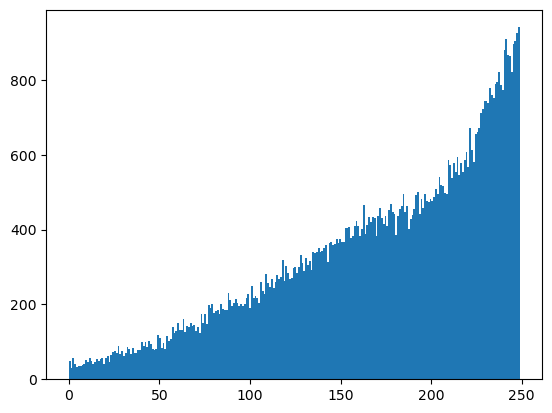

In [4]:
plt.hist(bhbh['label'], bins=n_bins)

In [5]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=bhbh['label'] 
)

## Model data and parameters

In [6]:
#Data
X = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'a', 'e']]
le = LabelEncoder()
#y = le.fit_transform(bhbh['label'])
y = bhbh['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

y_train = le.fit_transform(y_train)
#weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)


#parameters
n_estimators = 10
max_depth = 8
learning_rate = 0.3
grow_policy = 0
max_leaves = n_bins

param = {'objective': 'multi:softprob',
        'n_estimators' : 10, 
        'max_depth' : 2,
        'learning_rate' : 0.3,
        'grow_policy' : 0,
        #'max_leaves' : n_bins,
         'num_class': n_bins,
        'n_jobs' : -1
        }

In [7]:
model = XGBClassifier(param)

/home/giacomo/miniconda3/envs/dask/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [8]:
np.unique(np.array(y))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [9]:
model.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [10]:
y_train_predict = model.predict(X_train)
#prediction = le.inverse_transform(prediction)

In [11]:
y_train_predict.shape, X_train.shape

((56938,), (56938, 5))

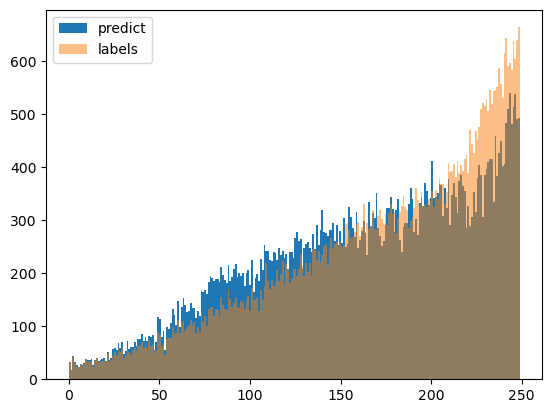

In [12]:
plt.hist(y_train_predict, bins=n_bins, alpha=1, label='predict')
plt.hist(y_train, alpha=0.5, bins=n_bins, label='labels')
plt.legend()

100 233


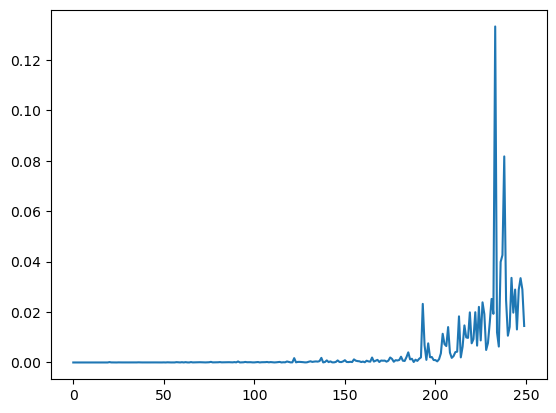

In [13]:
prob_y_train_pred = model.predict_proba(X_train)
prob_y_train_pred.shape

k = 5
plt.plot(range(0,n_bins), prob_y_train_pred[k])
print(y[k], y_train_predict[k])

In [14]:
y_test_pred = model.predict(X_test)
#y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_test_pred)
# print(cm)

# print(accuracy_score(y_test, y_test_pred, normalize=True))
# print(accuracy_score(y_train, y_train_predict))

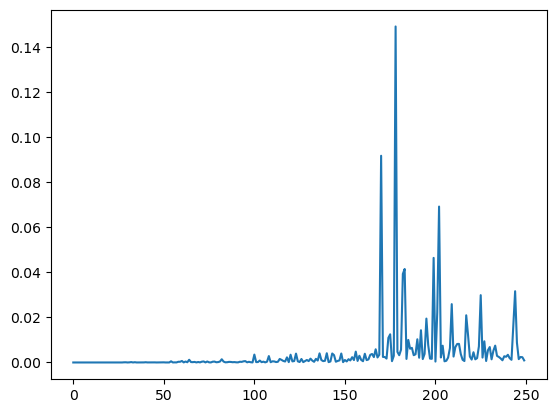

In [15]:
prob_y_test_pred = model.predict_proba(X_test)
plt.plot(range(0, n_bins), prob_y_test_pred[0])

In [16]:
label_values = np.arange(0, n_bins)

Text(0, 0.5, 'y_test_label_predict_max')

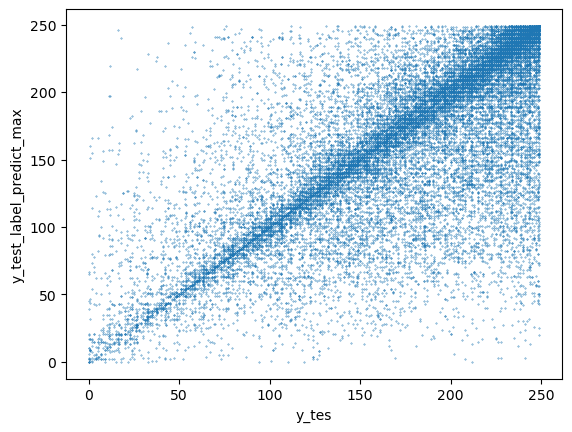

In [17]:
y_test_label_predict_max = np.argmax(prob_y_test_pred, axis=1)
plt.scatter(y_test, y_test_label_predict_max, s=0.1)
plt.xlabel('y_tes')
plt.ylabel('y_test_label_predict_max')

Text(0, 0.5, 'y_test_label_predict_mean')

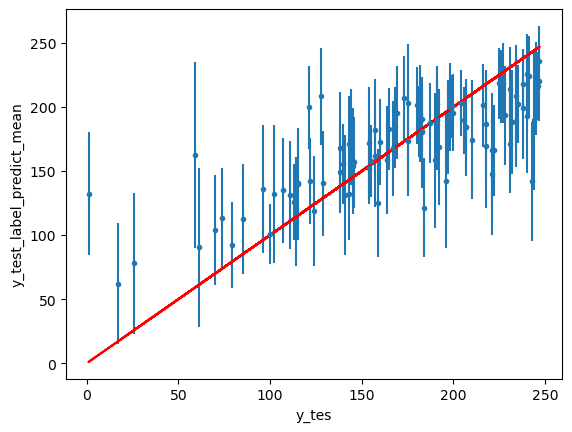

In [18]:
y_test_label_predict_mean = np.sum(prob_y_test_pred*(label_values), axis=1)
y_test_label_predict_variance = np.sum(prob_y_test_pred * (label_values.reshape(1,n_bins) - y_test_label_predict_mean.reshape(len(y_test_label_predict_mean), 1))**2, axis=1)
y_test_label_predict_std = np.sqrt(y_test_label_predict_variance)

plt.errorbar(y_test[:100], y_test_label_predict_mean[:100], yerr=y_test_label_predict_std[:100], fmt='.')
plt.plot(y_test[:100], y_test[:100], color='red')
plt.xlabel('y_tes')
plt.ylabel('y_test_label_predict_mean')

In [ ]:
chi = np.sum(((y_test_label_predict_mean - y_test)**2)/y_test_label_predict_variance)
chi_norm = chi/len(y_test)
print(chi)
print(chi_norm)